In [1]:
pip install -e FindDirection

ERROR: FindDirection is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
gym.make('findirection:FindDirEnv-v0')

In [3]:
import findirection
env = gym.make('findirection:FindDirEnv-v0')

In [5]:
from findirection.envs.fd1_env import FindDirection_v1

In [52]:
setup = { 'width': 6,
          'height': 6,
          'add_maze': True,
          'maze_seed': 42,
          'end': [5,5]
        }       

puddles = [((1,1),2),           
           ((3,1),2),
           ((4,2),2),
           ((0,3),2),
           ((2,4),2),
           ((1,5),2),]
setup['puddles'] = puddles

setup['side_panel'] = {'width':200}
env = FindDirection_v1(**setup)
env.render()

MultiCanvas(height=388, sync_image_data=True, width=588)

In [53]:
from tqdm.notebook import tqdm
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from findirection.envs.actions import Actions
import matplotlib.pyplot as plt

# 1000 ep
# run the environment, taking random actions
env.reset()


state_space = env.width * env.height
print("There are ", state_space, " possible states")

action_space = 5

print("There are ", action_space, " possible actions")


# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

Qtable_fd = initialize_q_table(state_space, action_space)

def epsilon_greedy_policy(Qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_int = random.uniform(0,1)
    # if random_int > greater than epsilon --> exploitation
    if random_int > epsilon:
        # Take the action with the highest value given a state
        # np.argmax can be useful here
        action = np.argmax(Qtable[state])
    # else --> exploration
    else:
        action = env.action_space.sample()

    return action

def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state])

    return action


# Training parameters
n_training_episodes = 1000 # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 2        # Total number of test episodes

# Environment parameters
env_id = "FindDirEnv-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005            # Exponential decay rate for exploration prob


def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    total_reward = []
    for episode in tqdm(range(n_training_episodes)):
        rw = 0
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        state = state_to_q(state)
        
        
        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)
            new_state = state_to_q(new_state)
            env.render() 
            # print(new_state, action)


            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])   

            # If done, finish the episode
            if done:
                break

            # Our state is the new state
            state = new_state
            
            info_str = f"{Actions(action): <5}: {new_state} reward = {reward}"  
            rw = rw + reward

            env.render(info = {'side_info': [((10,10),info_str)]}) 
        total_reward.append(rw)

    return Qtable, total_reward

def state_to_q(state):
    return state[0]*env.height + state[1]
Qtable_fd = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_fd)

There are  36  possible states
There are  5  possible actions


  0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
Qtable_fd

(array([[-6.03325408, -6.03325408, -5.29816219, -5.29816219, -6.03325408],
        [-6.03320969, -6.03325408, -4.54216375, -5.29816219, -5.50522687],
        [-5.29816219, -5.40183956, -4.52438125, -4.58442744, -5.29816219],
        [-4.52438125, -5.51899515, -3.709875  , -5.28538574, -4.52438125],
        [-4.94736926, -4.52438125, -6.709875  , -4.22997653, -5.19288778],
        [-4.58662939, -7.52438125, -2.96429165, -4.71517985, -4.94233387],
        [-6.03325408, -6.03325408, -5.29816219, -5.29816219, -6.03325408],
        [-5.29816219, -6.03325408, -4.52438125, -5.29816219, -5.59514595],
        [-5.29816219, -5.29816219, -4.52438125, -4.52438125, -5.29816219],
        [-4.52438125, -5.29816219, -3.709875  , -3.709875  , -4.52438125],
        [-3.709875  , -4.52438125, -3.70828525, -2.8525    , -5.29776472],
        [-2.8525    , -3.709875  , -1.95      , -2.8525    , -5.23872743],
        [-5.29816219, -5.29816219, -4.52438125, -4.52438125, -6.03325408],
        [-4.52438125, -5.

In [92]:
arr = reward_Q.copy()
for i in range (999):
    reward_Q[i+1] = -(abs(arr[i+1]) - abs(arr[i]))
reward_Q

[-85,
 -66,
 -117,
 -31,
 -12,
 -61,
 -97,
 -91,
 -53,
 -14,
 -30,
 -19,
 -66,
 -33,
 -8,
 -62,
 -67,
 -83,
 -99,
 -25,
 -105,
 -23,
 -111,
 -59,
 -117,
 -103,
 -38,
 -111,
 -54,
 -23,
 -120,
 -34,
 -18,
 -111,
 -104,
 -44,
 -36,
 -108,
 -18,
 -12,
 -117,
 -62,
 -111,
 -83,
 -71,
 -111,
 -106,
 -17,
 -108,
 -105,
 -60,
 -50,
 -111,
 -65,
 -58,
 -111,
 -114,
 -25,
 -24,
 -91,
 -87,
 -12,
 -41,
 -24,
 -117,
 -37,
 -38,
 -59,
 -34,
 -16,
 -85,
 -86,
 -111,
 -61,
 -102,
 -19,
 -19,
 -17,
 -104,
 -92,
 -39,
 -27,
 -120,
 -74,
 -102,
 -10,
 -111,
 -12,
 -120,
 -64,
 -26,
 -114,
 -111,
 -9,
 -35,
 -25,
 -40,
 -117,
 -24,
 -38,
 -59,
 -106,
 -86,
 -10,
 -92,
 -46,
 -70,
 -26,
 -13,
 -39,
 -69,
 -40,
 -108,
 -114,
 -45,
 -67,
 -81,
 -27,
 -76,
 -52,
 -58,
 -105,
 -12,
 -49,
 -17,
 -14,
 -24,
 -54,
 -108,
 -106,
 -37,
 -18,
 -77,
 -25,
 -18,
 -117,
 -100,
 -55,
 -103,
 -102,
 -15,
 -39,
 -104,
 -23,
 -26,
 -97,
 -26,
 -7,
 -108,
 -23,
 -18,
 -86,
 -62,
 -15,
 -29,
 -105,
 -85,
 -47,
 -29,
 -49,


In [114]:
import numpy as np
mean_reward_Q = np.mean(reward_Q)
st_reward_Q = np.std(reward_Q)
print(mean_reward_Q, st_reward_Q )

-32.665 28.68917522341833


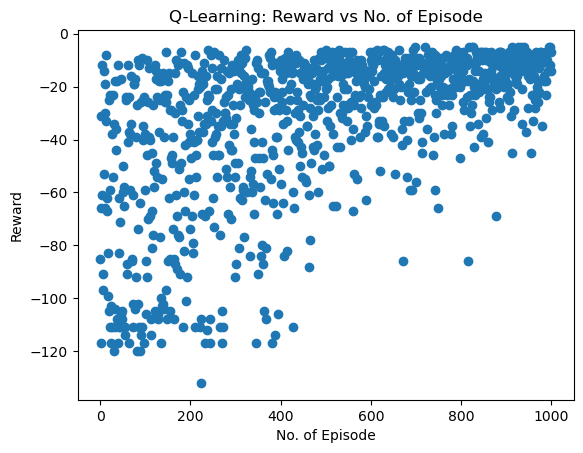

In [115]:
from matplotlib import pyplot as plt
x = list(range(1000))
plt.scatter(x,reward_Q)

plt.xlabel('No. of Episode')
plt.ylabel('Reward')
plt.title('Q-Learning: Reward vs No. of Episode')
plt.show()

In [107]:
Q_table = ([[-6.03325408, -6.03325408, -5.29816219, -5.29816219, -6.03325408],
        [-6.03320969, -6.03325408, -4.54216375, -5.29816219, -5.50522687],
        [-5.29816219, -5.40183956, -4.52438125, -4.58442744, -5.29816219],
        [-4.52438125, -5.51899515, -3.709875  , -5.28538574, -4.52438125],
        [-4.94736926, -4.52438125, -6.709875  , -4.22997653, -5.19288778],
        [-4.58662939, -7.52438125, -2.96429165, -4.71517985, -4.94233387],
        [-6.03325408, -6.03325408, -5.29816219, -5.29816219, -6.03325408],
        [-5.29816219, -6.03325408, -4.52438125, -5.29816219, -5.59514595],
        [-5.29816219, -5.29816219, -4.52438125, -4.52438125, -5.29816219],
        [-4.52438125, -5.29816219, -3.709875  , -3.709875  , -4.52438125],
        [-3.709875  , -4.52438125, -3.70828525, -2.8525    , -5.29776472],
        [-2.8525    , -3.709875  , -1.95      , -2.8525    , -5.23872743],
        [-5.29816219, -5.29816219, -4.52438125, -4.52438125, -6.03325408],
        [-4.52438125, -5.29816219, -4.52438125, -3.709875  , -5.34091863],
        [-4.52438125, -5.29816219, -3.709875  , -3.709875  , -5.29816219],
        [-3.709875  , -4.52438125, -2.8525    , -3.709875  , -7.52438125],
        [-3.709875  , -4.52438125, -2.8525    , -2.8525    , -5.02831144],
        [-2.8525    , -3.709875  , -1.95      , -2.8525    , -3.93794877],
        [-4.52438125, -4.52438125, -3.709875  , -4.51922233, -6.03325408],
        [-4.52438125, -4.52438125, -4.52405959, -3.709875  , -8.29816219],
        [-3.709875  , -3.71045277, -3.709875  , -2.8525    , -5.29816219],
        [-3.709875  , -7.52438125, -2.8525    , -2.8525    , -4.52438125],
        [-2.8525    , -3.709875  , -1.95      , -1.95      , -3.08859202],
        [-1.95      , -3.709875  , -1.        , -1.95      , -5.8525    ],
        [-4.52438125, -4.52438125, -3.709875  , -6.709875  , -4.52438125],
        [-4.41302685, -4.52438125, -3.709875  , -4.50484253, -4.52438124],
        [-3.709875  , -4.52438125, -2.8525    , -2.8525    , -3.709875  ],
        [-2.8525    , -4.38349823, -2.8525    , -1.95      , -3.709875  ],
        [-2.8525    , -6.709875  , -1.95      , -1.95      , -6.709875  ],
        [-1.95      , -2.8525    , -1.        , -1.95      , -2.8525    ],
        [-3.709875  , -3.709875  , -3.709875  , -2.8525    , -4.52438125],
        [-3.709875  , -3.709875  , -3.709875  , -2.8525    , -4.3724385 ],
        [-2.8525    , -3.709875  , -2.8525    , -1.95      , -3.709875  ],
        [-2.8525    , -3.709875  , -2.8525    , -1.95      , -3.709875  ],
        [-1.95      , -2.8525    , -1.95      , -1.        , -2.8525    ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.    ]])

In [112]:
import pandas as pd
df = pd.DataFrame(Q_table)
df.style.background_gradient(cmap='Blues')

,0,1,2,3,4
0,-6.033254,-6.033254,-5.298162,-5.298162,-6.033254
1,-6.033210,-6.033254,-4.542164,-5.298162,-5.505227
2,-5.298162,-5.401840,-4.524381,-4.584427,-5.298162
3,-4.524381,-5.518995,-3.709875,-5.285386,-4.524381
4,-4.947369,-4.524381,-6.709875,-4.229977,-5.192888
5,-4.586629,-7.524381,-2.964292,-4.715180,-4.942334
6,-6.033254,-6.033254,-5.298162,-5.298162,-6.033254
7,-5.298162,-6.033254,-4.524381,-5.298162,-5.595146
8,-5.298162,-5.298162,-4.524381,-4.524381,-5.298162
9,-4.524381,-5.298162,-3.709875,-3.709875,-4.524381
